In [1]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use("fivethirtyeight")
pd.set_option('display.max_colwidth', 80)
import matplotlib.patheffects as path_effects
import nltk
import numpy as np
import seaborn as sns
import gensim
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# 1. Data

In [3]:
reviews = pd.read_csv('/content/tripadvisor_hotel_reviews.csv')
reviews = reviews.dropna()
reviews = reviews.drop_duplicates(subset='Review')

In [4]:
reviews.head(5)

,Review,Rating
0,"nice hotel expensive parking got good deal stay hotel anniversary, arrived l...",4
1,ok nothing special charge diamond member hilton decided chain shot 20th anni...,2
2,nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.po...,3
3,"unique, great stay, wonderful time hotel monaco, location excellent short st...",5
4,"great stay great stay, went seahawk game awesome, downfall view building did...",5


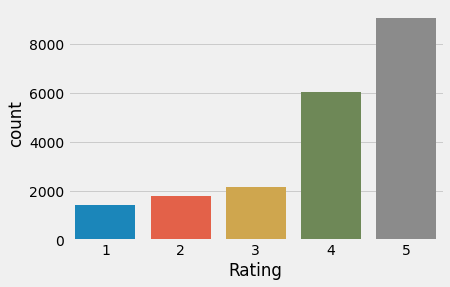

In [5]:
# Create a bar plot with value counts

sns.countplot(x='Rating', data=reviews)

# 2.  Data Cleaning and Preprocessing

In [6]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [7]:
def text_preprocessing(text):
    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Expand contractions
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
        
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text) 

    # Tokenize each word
    text = nltk.WordPunctTokenizer().tokenize(text)

    # Lemmatize each word
    text = [nltk.stem.WordNetLemmatizer().lemmatize(token, pos='v') for token in text if len(token)>1]

    return text

def to_string(text):
    # Convert list to string
    text = ' '.join(map(str, text))

    return text

In [8]:
reviews['Review_Clean_List'] = list(map(text_preprocessing, reviews.Review))

In [9]:
reviews['Review_Clean'] = list(map(to_string, reviews['Review_Clean_List']))

In [10]:
pd.set_option('display.max_colwidth', 150)
reviews.sample()

,Review,Rating,Review_Clean_List,Review_Clean
2258,"great time stayed w jan 1-4th sugar bowl game great time team did n't come close winning, hotel room nice clean bathroom shower unit, beds soft gr...",4,"[great, time, stay, jan, 4th, sugar, bowl, game, great, time, team, do, come, close, win, hotel, room, nice, clean, bathroom, shower, unit, bed, s...",great time stay jan 4th sugar bowl game great time team do come close win hotel room nice clean bathroom shower unit bed soft great sleep prone co...


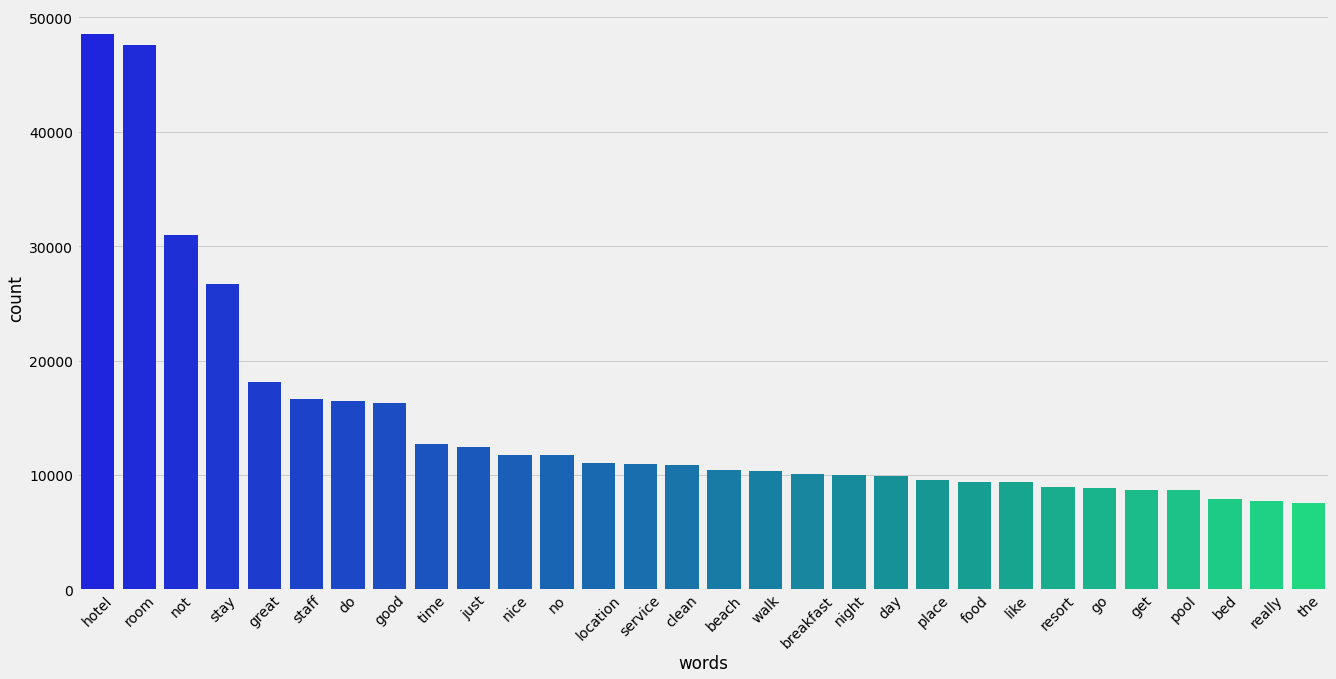

In [11]:
# Join  text together
review_words = ','.join(list(reviews['Review_Clean'].values))

# Count each word
Counter = Counter(review_words.split())
most_frequent = Counter.most_common(30)

fig = plt.figure(1, figsize = (20,10))
_ = pd.DataFrame(most_frequent, columns=("words","count"))
sns.barplot(x = 'words', y = 'count', data = _, palette = 'winter')
plt.xticks(rotation=45);

In [12]:
stopwords_list = stopwords.words('english')
stopwords_list.extend(['hotel', 'room', 'stay'])

In [13]:
reviews['Review_Clean_List'] = [[word for word in line if word not in stopwords_list] for line in reviews['Review_Clean_List']]

In [14]:
reviews['Review_Clean'] = list(map(to_string, reviews['Review_Clean_List']))

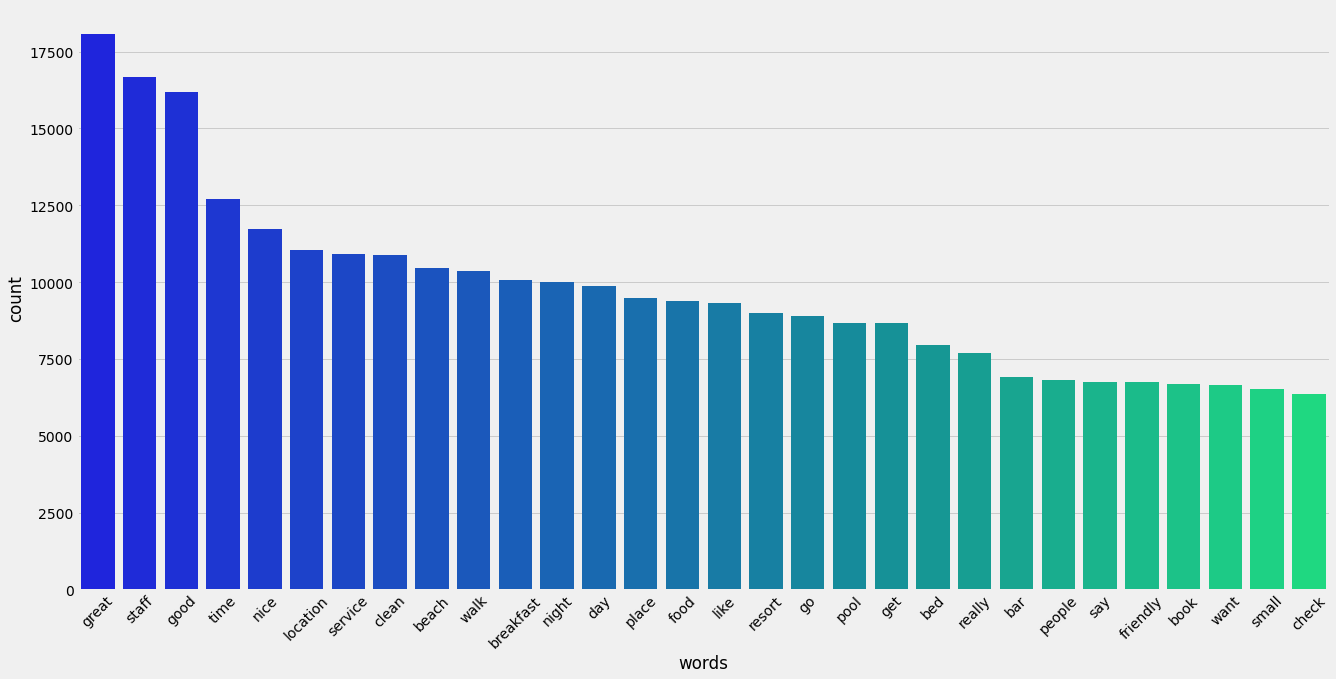

In [15]:
from collections import Counter

# Join  text together
review_words = ','.join(list(reviews['Review_Clean'].values))

# Count each word
Counter = Counter(review_words.split())
most_frequent = Counter.most_common(30)

# Bar plot of frequent words
fig = plt.figure(1, figsize = (20,10))
_ = pd.DataFrame(most_frequent, columns=("words","count"))
sns.barplot(x = 'words', y = 'count', data = _, palette = 'winter')
plt.xticks(rotation=45);

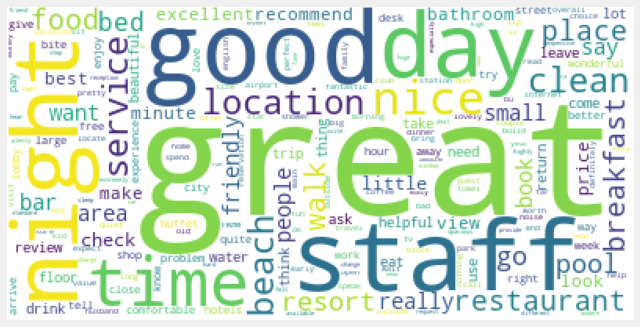

In [16]:
# Generate the word cloud
wordcloud = WordCloud(background_color="white",
                      max_words= 200,
                      contour_width = 8,
                      contour_color = "steelblue",
                      collocations=False).generate(review_words)
                      
# Visualize the word cloud
fig = plt.figure(1, figsize = (10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

# 3. Bag-of-Words

In [17]:
# Create Dictionary
id2word = gensim.corpora.Dictionary(reviews['Review_Clean_List'])

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in reviews['Review_Clean_List']]

# 4. Determining the Number of Topics

In [18]:
from gensim.models import CoherenceModel
# Compute Coherence Score
number_of_topics = []
coherence_score = []
for i in range(1,7):
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           iterations=50,
                                           num_topics=i)
  coherence_model_lda = CoherenceModel(model=lda_model, texts=reviews['Review_Clean_List'], dictionary=id2word, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  number_of_topics.append(i)
  coherence_score.append(coherence_lda);

In [19]:
topic_coherence = pd.DataFrame({'number_of_topics':number_of_topics, 'coherence_score':coherence_score})

In [20]:
topic_coherence

,number_of_topics,coherence_score
0,1,0.287214
1,2,0.315387
2,3,0.358704
3,4,0.336015
4,5,0.343504
5,6,0.323252


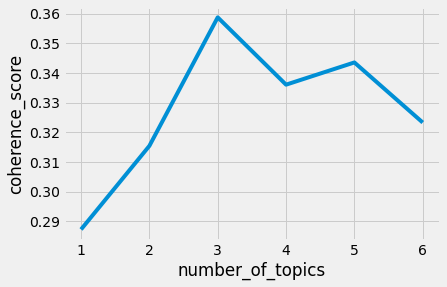

In [21]:
sns.lineplot(data=topic_coherence, x='number_of_topics', y='coherence_score')

# 5. Topic Modeling with LDA

In [ ]:
n_topics = 3

from sklearn.decomposition import LatentDirichletAllocation

# lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', random_state=0, verbose=0)
# lda_topic_matrix = lda_model.fit_transform(document_term_matrix)
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True);
lda_topic_matrix = lda_model;

In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} Word: {}".format(idx, topic))
    print("\n")

Topic: 0 Word: 0.022*"beach" + 0.021*"pool" + 0.018*"food" + 0.017*"resort" + 0.015*"great" + 0.012*"time" + 0.011*"good" + 0.009*"bar" + 0.009*"drink" + 0.008*"go"


Topic: 1 Word: 0.010*"night" + 0.008*"say" + 0.008*"get" + 0.007*"check" + 0.007*"time" + 0.007*"go" + 0.007*"leave" + 0.007*"day" + 0.006*"service" + 0.006*"like"


Topic: 2 Word: 0.020*"great" + 0.014*"staff" + 0.013*"location" + 0.013*"good" + 0.012*"breakfast" + 0.011*"walk" + 0.010*"nice" + 0.009*"clean" + 0.008*"excellent" + 0.007*"helpful"




# 6. Visualising with pyLDAvis

In [ ]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 26.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=504d44b8c1773dc08ad9082048cf0ecc9ccb783408c4032883b05798a41b8ade
  Stored in directory: /root/.cache/pip/wheels/90/61/ec/9dbe9efc3acf9c4e37ba70fbbcc3f3a0ebd121060aa593181a
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=de2a777ec7bc0300f6352d386453e951c9c09def13fbc9e6acb64d35a994b5e8
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built pyLDAvis sklearn


In [ ]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [ ]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.066913 -0.190199       1        1  38.785768
1     -0.169109  0.142220       2        1  37.946630
0      0.236022  0.047978       3        1  23.267602, topic_info=        Term          Freq         Total Category  logprob  loglift
4846   beach   9912.000000   9912.000000  Default  30.0000  30.0000
1076    pool   9298.000000   9298.000000  Default  29.0000  29.0000
4797  resort   7420.000000   7420.000000  Default  28.0000  28.0000
25     great  21625.000000  21625.000000  Default  27.0000  27.0000
465     food   9766.000000   9766.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
30      like   2720.212542   9173.634085   Topic3  -5.0964   0.2425
527      lot   2342.160181   5491.357662   Topic3  -5.2460   0.6060
189    staff   2704.647272  15403.154873   Topic3  -5.1021  -0.2815
204     want   2359.357168   6968.353429   Topic3  -5.2387   0.3751
406    place   2287.281569   9610.236229   Topic3  -5.2697   0.0226

[227 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1633      2  0.999409          00
438       1  0.999703      access
357       3  0.998841  activities
1130      2  0.999673         air
313       1  0.707043        area
...     ...       ...         ...
307       1  0.999421     weekend
310       1  0.033545        work
310       2  0.810449        work
310       3  0.156096        work
884       2  0.999529       wrong

[313 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])